In [2]:
import sys
import torch
import os
from os import makedirs
import numpy as np
import open3d as o3d
from random import randint
from scipy.spatial.transform import Rotation
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import math
import scenenet_pb2 as sn

np.set_printoptions(suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def normalize(v):
    return v/np.linalg.norm(v)

def camera_to_world_matrix(view_pose):
    camera_position = position_to_np_array(view_pose.camera)
    look_at = position_to_np_array(view_pose.lookat)
    up = np.array([0, 1, 0])

    # Calculate the forward, right, and up vectors
    forward = normalize(look_at - camera_position)
    right = normalize(np.cross(up, forward))
    up = np.cross(forward, right)

    # Create a 4x4 transformation matrix
    world_to_camera_matrix = np.eye(4)
    world_to_camera_matrix[:3, 0] = right
    world_to_camera_matrix[:3, 1] = up
    world_to_camera_matrix[:3, 2] = -forward
    world_to_camera_matrix[:3, 3] = camera_position

    return world_to_camera_matrix

def world_to_camera_with_pose(view_pose):
    lookat_pose = position_to_np_array(view_pose.lookat)
    camera_pose = position_to_np_array(view_pose.camera)
    up = np.array([0,1,0])
    R = np.diag(np.ones(4))
    R[2,:3] = normalize(lookat_pose - camera_pose)
    R[0,:3] = normalize(np.cross(R[2,:3],up))
    R[1,:3] = -normalize(np.cross(R[0,:3],R[2,:3]))
    T = np.diag(np.ones(4))
    T[:3,3] = -camera_pose
    return R.dot(T)

def camera_to_world_with_pose(view_pose):
    return np.linalg.inv(world_to_camera_with_pose(view_pose))

def camera_intrinsic_transform(vfov=45,hfov=60,pixel_width=320,pixel_height=240):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[2,2] = 1
    camera_intrinsics[0,0] = (pixel_width/2.0)/math.tan(math.radians(hfov/2.0))
    camera_intrinsics[0,2] = pixel_width/2.0
    camera_intrinsics[1,1] = (pixel_height/2.0)/math.tan(math.radians(vfov/2.0))
    camera_intrinsics[1,2] = pixel_height/2.0
    return camera_intrinsics

def position_to_np_array(position,homogenous=False):
    if not homogenous:
        return np.array([position.x,position.y,position.z])
    return np.array([position.x,position.y,position.z,1.0])

def interpolate_poses(start_pose,end_pose,alpha):
    assert alpha >= 0.0
    assert alpha <= 1.0
    camera_pose = alpha * position_to_np_array(end_pose.camera)
    camera_pose += (1.0 - alpha) * position_to_np_array(start_pose.camera)
    lookat_pose = alpha * position_to_np_array(end_pose.lookat)
    lookat_pose += (1.0 - alpha) * position_to_np_array(start_pose.lookat)
    timestamp = alpha * end_pose.timestamp + (1.0 - alpha) * start_pose.timestamp
    pose = sn.Pose()
    pose.camera.x = camera_pose[0]
    pose.camera.y = camera_pose[1]
    pose.camera.z = camera_pose[2]
    pose.lookat.x = lookat_pose[0]
    pose.lookat.y = lookat_pose[1]
    pose.lookat.z = lookat_pose[2]
    pose.timestamp = timestamp
    return pose

def extract_intrinsics(intrinsic_matrix):
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]
    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2] 

    return cx, cy, fx, fy


def findTrajectoryfromSceneId(scene_id, trajectories):
    for traj in trajectories.trajectories:
        traj_scene_id = traj.render_path.split('/')[-1]
        if scene_id == traj_scene_id:
            return traj
    return None

In [4]:
scene_path = "E:\\Uni Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\SceneNet\\train"
protobuf_path = os.path.join(scene_path, "scenenet_rgbd_train_0.pb")

# Read the protobuf file
trajectories = sn.Trajectories()
try:
    with open(protobuf_path,'rb') as f:
        trajectories.ParseFromString(f.read())
except IOError:
    print('Scenenet protobuf data not found at location:{0}'.format(scene_path))
    print('Please ensure you have copied the pb file to the data directory')

# Extracting the camera intrinsics
intrinsic_matrix = camera_intrinsic_transform()
image_width = 320
image_height = 240
FovX = 60
FovY = 45

# Select scene trajectory
scene_id = '784'
traj = findTrajectoryfromSceneId(scene_id,trajectories)

scene_path = os.path.join(scene_path, scene_id)
images_path = os.path.join(scene_path, "photo")
depths_path = os.path.join(scene_path, "depth")
ply_path = os.path.join(scene_path, "ply")

print(scene_id)
print(scene_path)
print(images_path)
print(depths_path)

784
E:\Uni Siegen\SA\P-GPU\Code\gaussian-splatting\data\SceneNet\train\784
E:\Uni Siegen\SA\P-GPU\Code\gaussian-splatting\data\SceneNet\train\784\photo
E:\Uni Siegen\SA\P-GPU\Code\gaussian-splatting\data\SceneNet\train\784\depth


In [10]:
traj.render_path

'0/784'

In [11]:
def getPCD(points, colors=None):
    # Extract the transformed X, Y, Z coordinates
    X = points[0, :]
    Y = points[1, :]
    Z = points[2, :]
    # Stack the global coordinates
    point_cloud_points = np.vstack((X, Y, Z)).T
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud_points)
    # Add color to the point cloud
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

def getArrowMesh():
    arrow = o3d.geometry.TriangleMesh.create_arrow(cylinder_radius=0.1,
                                               cone_radius=0.20,
                                               cylinder_height=0.25,
                                               cone_height=0.1,
                                               resolution=20,
                                               cylinder_split=4,
                                               cone_split=1)
    arrow.compute_vertex_normals()
    arrow.paint_uniform_color([1, 0, 0])
    return arrow


In [12]:
# Get the list of files in the directory
depth_files = os.listdir(depths_path)
image_files = os.listdir(images_path)


# Sort the files to process depth and color images together
depth_files = sorted(depth_files, key=lambda x: int(x.split('.')[0]))

start_index = 0
ply_files = os.listdir(ply_path)
if len(ply_files) > 0:
    start_index = int(ply_files[-1].split('.')[0])

# frame_step = 5
# Loop through each pair of depth and color images
# for i in tqdm(range(1)):

print("Number of files:", len(depth_files))
print("Start index:", start_index)

Number of files: 300
Start index: 0


In [13]:
def pixel_to_ray(pixel,vfov=45,hfov=60,pixel_width=320,pixel_height=240):
    x, y = pixel
    x_vect = math.tan(math.radians(hfov/2.0)) * ((2.0 * ((x+0.5)/pixel_width)) - 1.0)
    y_vect = math.tan(math.radians(vfov/2.0)) * ((2.0 * ((y+0.5)/pixel_height)) - 1.0)
    return (x_vect,y_vect,1.0)

def normalised_pixel_to_ray_array(width=320,height=240):
    pixel_to_ray_array = np.zeros((height,width,3))
    for y in range(height):
        for x in range(width):
            pixel_to_ray_array[y,x] = normalize(np.array(pixel_to_ray((x,y),pixel_height=height,pixel_width=width)))
    return pixel_to_ray_array

def points_in_camera_coords(depth_map,pixel_to_ray_array):
    assert depth_map.shape[0] == pixel_to_ray_array.shape[0]
    assert depth_map.shape[1] == pixel_to_ray_array.shape[1]
    assert len(depth_map.shape) == 2
    assert pixel_to_ray_array.shape[2] == 3
    camera_relative_xyz = np.ones((depth_map.shape[0],depth_map.shape[1],4))
    for i in range(3):
        camera_relative_xyz[:,:,i] = depth_map * pixel_to_ray_array[:,:,i]
    return camera_relative_xyz

def flatten_points(points):
    return points.reshape(-1, 4)

def reshape_points(height,width,points):
    other_dim = points.shape[1]
    return points.reshape(height,width,other_dim)

def transform_points(transform,points):
    assert points.shape[2] == 4
    height = points.shape[0]
    width = points.shape[1]
    points = flatten_points(points)
    return reshape_points(height,width,(transform.dot(points.T)).T)

def reshape_for_pcd(points_img):
    points_flat = points_img.reshape(-1,4)
    x = points_flat[:,0]
    y = points_flat[:,1]
    z = points_flat[:,2]
    w = points_flat[:,3]
    points_reshaped = np.array([x,y,z,w])
    return points_reshaped

def getWorld2ViewC(R, t, translate=np.array([0.0, 0.0, 0.0]), scale=1.0):
    # Add Homogeneous Coordinate
    Rt = np.eye(4)
    Rt[:3, :3] = R
    Rt[:3, 3] = t

    # Add Translation and Scale
    C2W = Rt
    cam_center = C2W[:3, 3]
    cam_center = (cam_center + translate) * scale
    C2W[:3, 3] = cam_center

    return np.float32(C2W)

def getViewTransformationsfromView(view):
    ground_truth_pose = interpolate_poses(view.shutter_open,view.shutter_close,0.5)
    W2C = world_to_camera_with_pose(ground_truth_pose)
    C2W = camera_to_world_with_pose(ground_truth_pose)
    return W2C, C2W

In [18]:
# Convert Depth Images to Point Clouds
# Initialize an empty point cloud
point_cloud = o3d.geometry.PointCloud()
Rpcd = None
resolution_scale = 1
arrows = o3d.geometry.TriangleMesh()

# Intrinsic parameters of the camera (you may need to adjust these values)
cx, cy, fx, fy = extract_intrinsics(intrinsic_matrix)

cached_pixel_to_ray_array = normalised_pixel_to_ray_array()

# Using Numpy to create point clouds
# for i in tqdm(range(start_index, len(depth_files),frame_step)):
# for i in range(start_index, len(files),frame_step):
# for i in tqdm(range(0,6,2)):
for i in tqdm(range(100)):
    view = traj.views[i]
    depth_file_name = depth_files[i]
    image_file_name = image_files[i]

    depth_file = os.path.join(depths_path, depth_file_name)
    image_file = os.path.join(images_path, image_file_name)

    # print("Depth File:", depth_file)

    # Get the corresponding color image
    color_file = os.path.join(image_file)
    color_image = cv2.imread(color_file)
    depth_image = cv2.imread(depth_file, cv2.IMREAD_ANYDEPTH)
    
    frame_id = view.frame_num

    width, height = color_image.shape[1], color_image.shape[0]

    # Get camera pose
    ground_truth_pose = interpolate_poses(view.shutter_open,view.shutter_close,0.5)
    W2C = world_to_camera_with_pose(ground_truth_pose)
    C2W = camera_to_world_with_pose(ground_truth_pose)
    
    # flip_YZ = np.array([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])
    # C2W = np.dot(C2W, flip_YZ)

    # RGB Image
    color_array = np.asarray(color_image)
    color_array = color_array[:, :, :3]
    rgb_values = color_array.reshape((-1, 3)) / 255.0

    # Depth Image
    depth_array = np.asarray(depth_image)
    depth_scale = 1.0  / 1000

    # Grid Based Point Cloud
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    u = u.flatten()
    v = v.flatten()
    depth = depth_array.flatten() * depth_scale
    X = ((u - cx) * depth / fx)
    Y = ((v - cy) * depth / fy)
    Z = depth
    points_camera = np.vstack((X, Y, Z, np.ones_like(X)))

    # Create a point cloud from the depth image
    rescaled_depth = depth_array * depth_scale
    # print("Rescaled Depth:", np.min(rescaled_depth), np.max(rescaled_depth))
    points_in_camera = points_in_camera_coords(rescaled_depth ,cached_pixel_to_ray_array)
    points_in_camera_reshaped = reshape_for_pcd(points_in_camera)
    
    # Transform to global coordinates
    points_in_world = transform_points(C2W,points_in_camera)
    points_in_world_reshaped = reshape_for_pcd(points_in_world)    
    points_global = points_in_world_reshaped

    # Transform points again to camera coordinates and check
    if False:
        # Extract the transformed X, Y, Z coordinates
        R = W2C[:3, :3]
        t = W2C[:3, 3]
        W2C = getWorld2ViewC(R, t)
        # W2C = np.dot(flip_YZ, W2C)
        points_camera_again =  np.dot(W2C,points_global)
        pcd = getPCD(points_camera_again, rgb_values)
        # print('PCA:', np.shape(points_camera_again), points_camera_again[2, :])
        # Transform the points to OpenCV coordinate system
        # pcd.transform([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])
        point_cloud += pcd

    if False:
        pcd = getPCD(points_in_camera_reshaped, rgb_values)
        point_cloud += pcd

    # Extract the transformed X, Y, Z coordinates
    X_global = points_global[0, :] / points_global[3 , :]
    Y_global = points_global[1, :] / points_global[3 , :]
    Z_global = points_global[2, :] / points_global[3 , :]
    # Stack the global coordinates
    point_cloud_global = np.vstack((X_global, Y_global, Z_global)).T

    # Create an Open3D PointCloud
    pcd = o3d.geometry.PointCloud()
    # Set the points in the PointCloud 
    pcd.points = o3d.utility.Vector3dVector(point_cloud_global)

    # print("Point Cloud Shape:", np.shape(point_cloud_global))

    # Flip the point cloud
    # pcd.transform([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])

    # Add color to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(rgb_values)

    # if i == 0:
    #     Rpcd = pcd
            
    # Save the point cloud to a file
    ply_file_path = os.path.join(ply_path, str(frame_id)+ ".ply")    
    o3d.io.write_point_cloud(ply_file_path, pcd)

    # Merge current point cloud with the overall point cloud
    point_cloud += pcd

    # Add camera Position
    arrow = getArrowMesh()
    arrow.transform(C2W)
    arrows += arrow

    # Clear memory
    depth_image = None
    color_image = None
    depth_array = None
    color_array = None
    pcd = None


# Create an Open3D mesh representing coordinate axes
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0, 0, 0])

geometry_list = [point_cloud, arrows, axes] # axes, arrow
# o3d.visualization.draw_geometries(geometry_list)

pcd = None
axes = None

100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


In [24]:
def getProjectionMatrixTorch(znear, zfar, fovX, fovY):
    tanHalfFovY = math.tan((np.radians(fovY) / 2))
    tanHalfFovX = math.tan((np.radians(fovX) / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

def showRasterizedImageTorch(u,v, colors):
    image_width, image_height = width, height
    raster = torch.zeros((image_height, image_width, 3), dtype=torch.uint8 , device=colors.device)

    # Create Indices
    u_long = u.to(torch.long)
    v_long = v.to(torch.long)

    # print(u_long.min(), u_long.max())

    # Store Points and Colors
    raster[v_long, u_long] = (colors * 255).to(torch.uint8)
    raster = raster.cpu().numpy()
    plt.imshow(raster.astype(int))
    plt.show()

In [20]:
frame_id = '0'
view = traj.views[0]
ply_file_path = os.path.join(ply_path, frame_id + ".ply") 
Rpcd = o3d.io.read_point_cloud(ply_file_path)
points = torch.tensor(Rpcd.points, dtype=torch.float32, device='cuda')
colors = torch.tensor(Rpcd.colors, dtype=torch.float32, device='cuda')

C:\Users\rvisw\AppData\Local\Temp\ipykernel_23376\4167453476.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  points = torch.tensor(Rpcd.points, dtype=torch.float32, device='cuda')


In [21]:
points.shape

torch.Size([76800, 3])

fovX: 60
fovY: 45
znear 0.01
zfar 100
fovX 60
fovY 45
W2C: [[-0.97482455  0.          0.22297331 -4.71262499]
 [-0.11887642 -0.84602582 -0.51971983  4.24208939]
 [ 0.18864118 -0.53314192  0.82472674 -1.73442008]
 [ 0.          0.          0.          1.        ]]
Projection: tensor([[ 1.7321,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4142,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0001, -0.0100],
        [ 0.0000,  0.0000,  1.0000,  0.0000]])
FP: [[-1.68844562  0.          0.3862011  -8.16250577]
 [-0.28699308 -2.04248709 -1.25471472 10.24131013]
 [ 0.18866005 -0.53319525  0.82480923 -1.74459455]
 [ 0.18864118 -0.53314192  0.82472674 -1.73442008]]
View Space Extent: tensor(0.9663, device='cuda:0') tensor(4.9612, device='cuda:0')
Clip Space: torch.Size([76800, 4]) tensor(-4.9457, device='cuda:0') tensor(4.9612, device='cuda:0')
NDC: torch.Size([76800, 3]) tensor(-0.9969, device='cuda:0') tensor(0.9981, device='cuda:0')
IS: torch.Size([76800, 3]) tensor(0.0016, device='cuda

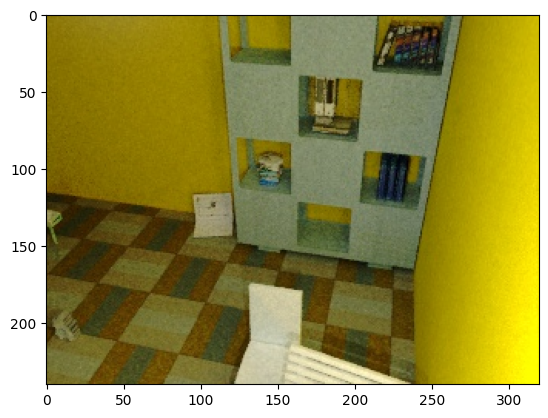

In [25]:
# Rasterize Point Clouds
W2C, C2W = getViewTransformationsfromView(view)

# print(frame_id, C2W)
# print(width, height)

# Calculate projection matrix from camera to world
# R = W2C[:3, :3]
# t = W2C[:3, 3]
# W2C = getWorld2ViewC(R, t)

# Flip the Z Axis
# W2C = np.dot(np.array([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]]), W2C)

image_width, image_height = width, height

# cx = rgb_camera_params['cx,cy,fx,fy'][0]
# cy = rgb_camera_params['cx,cy,fx,fy'][1]
# fx = rgb_camera_params['cx,cy,fx,fy'][2] 
# fy = rgb_camera_params['cx,cy,fx,fy'][3]

# # Normalized intrinsic parameters
# fx_norm = 2 * fx / image_width
# fy_norm = 2 * fy / image_height
# cx_norm = (2 * cx - image_width) / image_width
# cy_norm = (2 * cy - image_height) / image_height

zNear, zFar = 0.01, 100

# # Projection matrix
# P1 = np.array([
#     [fx_norm, 0, cx_norm, 0],
#     [0, fy_norm, cy_norm, 0],
#     [0, 0, -(zFar + zNear) / (zFar - zNear), -2 * zFar * zNear / (zFar - zNear)],
#     [0, 0, -1, 0]
# ])
# FullProjection = np.dot(P1, W2C)

fovX = FovX
fovY = FovY

print("fovX:", fovX)
print("fovY:", fovY)

P2 = getProjectionMatrixTorch(zNear, zFar, fovX, fovY)
FullProjection = np.dot(P2, W2C)
projection_matrix = torch.tensor(FullProjection, dtype=torch.float32, device='cuda')

print('W2C:',W2C)
print('Projection:', P2)
print('FP:',FullProjection)

points_homogeneous = torch.cat((points, torch.ones(points.shape[0], 1, device=points.device)), dim=1)

# View Space
view_matrix = torch.tensor(W2C, dtype=torch.float32, device='cuda')
view_points = torch.matmul(points_homogeneous, view_matrix.t())
print('View Space Extent:', view_points[:,2].min(), view_points[:,2].max())

# Clip Space
projected_points_homogeneous = torch.matmul(points_homogeneous, projection_matrix.t())
print('Clip Space:', projected_points_homogeneous.shape, projected_points_homogeneous.min(), projected_points_homogeneous.max())

# Filter points outside clip space
# mask = (projected_points_homogeneous[:, 0] >= -1) & (projected_points_homogeneous[:, 0] < 1) & \
#        (projected_points_homogeneous[:, 1] >= -1) & (projected_points_homogeneous[:, 1] < 1 ) & \
#        (projected_points_homogeneous[:, 2] >= -1) & (projected_points_homogeneous[:, 2] < 1) 
# projected_points_homogeneous = projected_points_homogeneous[mask]

# Clip Space to NDC
assert projected_points_homogeneous.shape[1] == 4
# Extract x, y, z, w from the tensor
x, y, z, w = projected_points_homogeneous[:, 0], projected_points_homogeneous[:, 1], projected_points_homogeneous[:, 2], projected_points_homogeneous[:, 3]
x_ndc = x / w
y_ndc = y / w
z_ndc = z / w
projected_points_NDC = torch.stack((x_ndc, y_ndc, z_ndc), dim=1)
print('NDC:', projected_points_NDC.shape, projected_points_NDC.min(), projected_points_NDC.max())

# NDC to Image Space [-1,1] to [0,1]
projected_points_IS = (projected_points_NDC + 1) / 2
print('IS:', projected_points_IS.shape, projected_points_IS.min(), projected_points_IS.max())

# Filter points outside image space
mask = (projected_points_IS[:, 0] >= 0) & (projected_points_IS[:, 0] <= 1) & \
       (projected_points_IS[:, 1] >= 0) & (projected_points_IS[:, 1] <= 1 )  & \
       (projected_points_IS[:, 2] >= 0) & (projected_points_IS[:, 2] <= 1)
projected_points_IS = projected_points_IS[mask]

points_filtered = points[mask]
colors_filtered = colors[mask]

print('Values: ', points_filtered.shape, colors_filtered.shape)

u = projected_points_IS[:,0] * image_width
v = projected_points_IS[:,1] * image_height
showRasterizedImageTorch( u, v , colors_filtered)

In [ ]:
print(frame_id)
print(points)